In [1]:
import numpy as np
from matplotlib import pyplot as plt
from solarcell import solarcell

In [2]:
# Azur Space 3G30A triple-junction solar cells in a 24s12p configuration.
# Isc/Imp are specified in (A, A/C), Voc/Vmp are specified in (V, V/C).
# Temperature is specified in C. Intensity is unitless and scales Isc/Imp.

azur3g30a = solarcell(
    isc=(0.5196, 0.00036),  # short-circuit current, temp coefficient
    voc=(2.690, -0.0062),  # open-circuit voltage, temp coefficient
    imp=(0.5029, 0.00024),  # max-power current, temp coefficient
    vmp=(2.409, -0.0067),  # max-power voltage, temp coefficient
    area=30.18,  # solar cell area
    t=28,  # temperature at which the above parameters are specified
)

In [3]:
array = azur3g30a.array(t=np.full((24, 12), 80), g=np.ones((24, 12)))

print(array)

Isc  = 6.459840 A, Voc  = 56.82240 V
Imp  = 6.187802 A, Vmp  = 49.42809 V, Pmp  = 305.8513 W
Iunc = 0.002657 A, Vunc =  0.03147 V, Punc =   0.2349 W


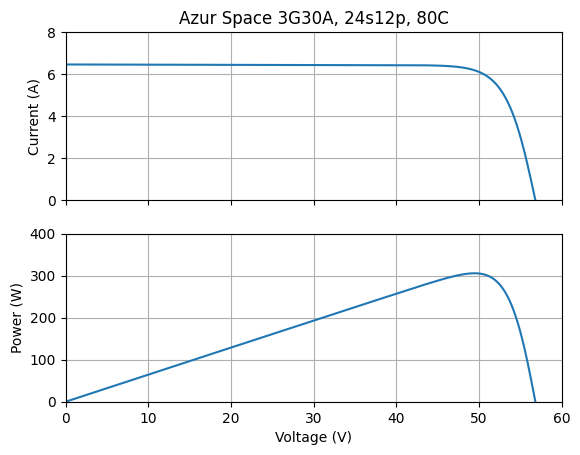

In [4]:
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)

v = np.linspace(0, array.voc, 1000)
ax0.plot(v, array.iv(v)), ax0.grid()
ax1.plot(v, array.pv(v)), ax1.grid()

ax0.set_xlim([0, 60]), ax1.set_xlabel("Voltage (V)")
ax0.set_ylim([0, 8]), ax0.set_ylabel("Current (A)")
ax1.set_ylim([0, 400]), ax1.set_ylabel("Power (W)")
ax0.set_title("Azur Space 3G30A, 24s12p, 80C")
plt.savefig("readme.png")